<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebooks/Example4_Polymer_Ensembles_Represented_by_Experimental_Molecular_Mass_Distributions_Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# @title Copyright & License (click to expand)

# MIT License

# Copyright (c) 2023 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Download Necessary Files

Downloading local python functions, tables, and dataset
from Github Repo [Polymer-Ensemble-Similarity](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity.git)

In [ ]:
!git clone https://github.com/olsenlabmit/Polymer-Ensemble-Similarity.git
!mv Polymer-Ensemble-Similarity/dataset .
!mv Polymer-Ensemble-Similarity/tables .
!mv Polymer-Ensemble-Similarity/utils .

# Import Required Libraries

In [3]:
import random
import numpy as np
import shutil
import sys
import os.path
import json
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import pandas as pd


if not shutil.which("rdkit"):
    !pip install -q rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

if not shutil.which("grakel"):
    !pip install grakel

if not shutil.which("dgl"):
    !pip install dgl

if not shutil.which("umap"):
    !pip install umap-learn

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert shutil.which("pyomo")

from pyomo.environ import *

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert shutil.which("cbc") or os.path.isfile("cbc")

from utils.load_networkx import networkx_feat
from utils import macro_unsupervised as unsup
from utils import plot

print("Import Required Libraries Done!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=cbb272f4b0bd91a9c7b0c3d41a8cd37522d621d58b5176b462d054793508a9a7
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=7c8c1845eeb4a8bd3f654fbecc62b1c961fb950c900f7f4875b68cad41576abd
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Import Required Libraries Done!


# Load Polymer Ensembles Represented by Experimental Molecular Mass Distributions in Example4



The raw data of these polystyrene molecular mass distributions (MMDs) about retention time ($t$) vs signal is provided by Prof. Brett P. Fors (Department of Chemistry and Chemical Biology, Cornell University) from their publication, [Kottish et al. “Shaping” the Future of Molecular Weight Distributions in Anionic Polymerization, ACS Macro Lett. 2016, 5, 7, 796-800](https://pubs.acs.org/doi/full/10.1021/acsmacrolett.6b00392)

<img src="https://drive.google.com/uc?export=view&id=1kXCZ7NjJZ3Q_rgUScDgkdTQtm_emoCMI"  width="50%">

Six polystyrene MMDs from the work of [Kottish et al. ACS Macro Lett. 2016, 5, 7, 796-800](https://pubs.acs.org/doi/full/10.1021/acsmacrolett.6b00392) are generated by varying initiator (sec-butyllithium) addition rates (constant (C), linearly ramped (L), and exponentially ramped (E)) and addition time (40 min and 60 min). C-40, for example, refers to a constant rate of initiator addition with an addition time of 40 minutes.

The parameters of these MMDs from  [Kottish et al. ACS Macro Lett. 2016, 5, 7, 796-800](https://pubs.acs.org/doi/full/10.1021/acsmacrolett.6b00392)
are shown in the following tables.

<img src="https://drive.google.com/uc?export=view&id=1DO4uDVihgHgJWjHfQHvJvkUbDEOEqJCN"  width="50%">


Since Example 4 directly loads the raw data of polymer MMDs, the preprocessing and data loading of Example 4 is different from [Example1](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example1_Two_Component_Polymer_Ensemble_Colab.ipynb), [Example2](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example2_First_order_Markov_Copolymer_Ensemble_onehot_Colab.ipynb) and [Example3](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example3_Nonlinear_Star_Polymer_Ensemble_Colab.ipynb).



## Loading the Raw MMDs

In [4]:
data_constant_rate_addition = pd.read_excel(
    "./dataset/Example4/ConstantRateAdditions.xlsx"
)
data_linearramp_addition = pd.read_excel("./dataset/Example4/Linearrampadditions.xlsx")
data_exponentialramp_addition = pd.read_excel(
    "./dataset/Example4/ExpRampAdditions.xlsx"
)

## Load the MMD Ensembles

For these polystyrene MMDs, the relationship between retention time ($t$ (min)) and molecular mass ($M$ (g/mol)) is as follows:

 $\lg (M) = -0.47*t + 10.92$.

This relationship equation is provided by Prof. Brett P. Fors and Jenny Hu.

Notes: Different GPCs might have different relationship between retention time ($t$ (min)) and molecular mass ($M$ (g/mol)). If users want to use their own dataset, users might need to update the relationship equation based on the setting of their GPCs.

Take C-40 ensemble for example, MMD_x_C_40 is the $M_i$, which is imported to the function **Similarity_Score_EMD_Calculation** as **ensemble** and MMD_y_C_40 is the mole fraction of $M_i$, which is imported to the **Similarity_Score_EMD_Calculation** as **weight**.
The range [1927:3478] is determined by 2% of the maximum signal by referring [Walsh et al. General route to design polymer molecular weight distributions through flow chemistry, Nat Commun 11, 3094 (2020)](https://doi.org/10.1038/s41467-020-16874-6)

In [5]:
MMD_x_C_40 = np.array(
    pow(10, (-0.47) * data_constant_rate_addition["Chromatogram RI (159)"] + 10.92)
)[1927:3478]
MMD_y_C_40_signal = np.array(data_constant_rate_addition["40 min"])[1927:3478]
MMD_y_C_40 = MMD_y_C_40_signal / MMD_x_C_40

MMD_x_C_60 = np.array(
    pow(10, (-0.47) * data_constant_rate_addition["Chromatogram RI (159)"] + 10.92)
)[1800:3660]
MMD_y_C_60_signal = np.array(data_constant_rate_addition["60 min"])[1800:3660]
MMD_y_C_60 = MMD_y_C_60_signal / MMD_x_C_60

MMD_x_L_40 = np.array(
    pow(10, (-0.47) * data_linearramp_addition["Chromatogram RI (163)"] + 10.92)
)[1768:3451]
MMD_y_L_40_signal = np.array(data_linearramp_addition["40 min"])[1768:3451]
MMD_y_L_40 = MMD_y_L_40_signal / MMD_x_L_40

MMD_x_L_60 = np.array(
    pow(10, (-0.47) * data_linearramp_addition["Chromatogram RI (163)"] + 10.92)
)[1597:3540]
MMD_y_L_60_signal = np.array(data_linearramp_addition["60 min"])[1597:3540]
MMD_y_L_60 = MMD_y_L_60_signal / MMD_x_L_60

MMD_x_E_40 = np.array(
    pow(10, (-0.47) * data_exponentialramp_addition["Chromatogram RI (161)"] + 10.92)
)[1785:3269]
MMD_y_E_40_signal = np.array(data_exponentialramp_addition["40 min"])[1785:3269]
MMD_y_E_40 = MMD_y_E_40_signal / MMD_x_E_40

MMD_x_E_60 = np.array(
    pow(10, (-0.47) * data_exponentialramp_addition["Chromatogram RI (161)"] + 10.92)
)[1647:3357]
MMD_y_E_60_signal = np.array(data_exponentialramp_addition["60 min"])[1647:3357]
MMD_y_E_60 = MMD_y_E_60_signal / MMD_x_E_60

# Visualize MMD Ensembles

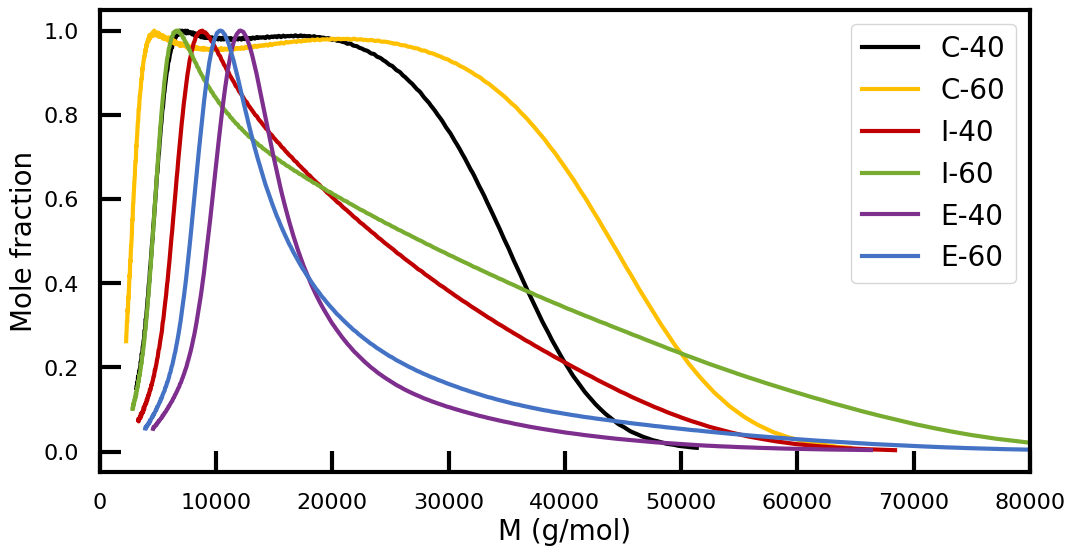

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

xmajorLocator = MultipleLocator(10000)

ymajorLocator = MultipleLocator(0.2)

plt.plot(MMD_x_C_40, MMD_y_C_40 / max(MMD_y_C_40), c="k", label="C-40", lw=3)
plt.plot(MMD_x_C_60, MMD_y_C_60 / max(MMD_y_C_60), c="#FFC000", label="C-60", lw=3)


plt.plot(MMD_x_L_40, MMD_y_L_40 / max(MMD_y_L_40), c="#C00000", label="I-40", lw=3)
plt.plot(MMD_x_L_60, MMD_y_L_60 / max(MMD_y_L_60), c="#77AC30", label="I-60", lw=3)


plt.plot(MMD_x_E_40, MMD_y_E_40 / max(MMD_y_E_40), c="#7E2F8E", label="E-40", lw=3)
plt.plot(MMD_x_E_60, MMD_y_E_60 / max(MMD_y_E_60), c="#4472C4", label="E-60", lw=3)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(3)
ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)

ax.tick_params(
    which="both",
    direction="in",
    colors="black",
    bottom=True,
    top=False,
    left=True,
    right=False,
    pad=15,
)
ax.tick_params(which="major", direction="in", length=15, labelsize=16, width=3)


plt.xlim(0, 80000)
plt.legend(fontsize=20)
plt.xlabel("M (g/mol)", size=20)
plt.ylabel("Mole fraction", size=20)
plt.show()

# Polymer Ensembles Similarity Function via Earth Mover's Distance

Use the earth mover's distance (EMD) to compute pairwise similarity scores between polymer ensembles.


$ EMD (P,Q)= \min_{F}\sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j}d_{i,j}$

$ {\rm subject\ to\ } f_{i,j} \geq 0, {\rm\ for\ any\ } \ 1 \leq i \leq m, 1 \leq j \leq n $

$     \sum_{j=1}^{n}f_{i,j} =w_{pi}, {\rm for\ any} \ 1 \leq i \leq m $

$     \sum_{i=1}^{m}f_{i,j} =w_{qj}, {\rm for\ any} \ 1 \leq j \leq n $

$     \sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j} = \sum_{i}^{m} w_{pi} = \sum_{j}^{n} w_{qj} = 1 $


One polymer ensemble is defined as $P = \{(p_1,w_{p_1}) ,(p_2,w_{p_2}),...,(p_i,w_{p_i}),...,(p_m,w_{p_m})\}$ has $m$ types of polymer chains, where $p_i$ represents a type of polymer chain and  $w_{p_i}>0$ is its corresponding weight, which can be the mole fraction of this polymer chain in the polymer ensemble. Similarly, the second ensemble $Q = {(q_1,w_{q_1}),(q_2,w_{q_2}),...,(q_j,w_{q_j}),...,(q_n,w_{q_n})}$ has $n$ types of polymer chains. The sums of the weights for $P$ and $Q$ are both normalized and equal to one.

The EMD linear optimization code  refers to [Transportation Networks, ND Pyomo Notebook](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/03.01-Transportation-Networks.html)

Once $EMD (P,Q)$ is calculated, the similarity score between $P$ and $Q$ is

$S(P,Q) = 1- EMD (P,Q)$


The distance ($d_{i,j}$) between one polymer molecule $p_i$ and another polymer molecule $q_j$ is calculated through graph edit distance. This part of the code builds on [GLAMOUR](https://github.com/learningmatter-mit/GLAMOUR) and networkx function [graph_edit_distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html).

$d(g_1, g_2) = 1- \exp(-\frac{\alpha \cdot GED(g_1, g_2)}{(N_1 + N_2)/2})$

where $g_i$ is the graph representation of one polymer molecule, $N_i$ is the number of nodes in graph $g_i$, $\alpha$ is a tunable parameter with the default value being 1. [Reference1](https://arxiv.org/abs/1808.05689), [Reference2](https://doi.org/10.1021/acs.macromol.3c00761)


Since calculating the GED is computationally expensive, an analytic approach along with the knowledge that all these MMDs are about linear polystyrenes is used here.
To evaluate $d_{i,j}$, a polymer graph representation is needed for every single value of measured molecular mass ($M_i$) in the MMDs. Since one of the end groups (*H) is implicit, the number of nodes can be computed as

<img src="https://drive.google.com/uc?export=view&id=1cWPWri7vla-yUi6z2H6ZXb3TQmsiJ7Hy"  width="50%">

$N_i=dp_i+1$

where $dp_i$ is the degree of polymerization computed from $M_i$. The value of 1 corresponds to the other end group, sec-butyl group. Since the polystyrene is linear, adding one repeat unit node means also adding one edge in the graph representation. GED between $M_i$ and $M_j$ can then be computed as two times the difference of the degree of polymerization. For nonlinear polymer, this equation may be also a suitable approximation approach if only the MMDs are known.

$GED(M_i,M_j)=2\cdot |dp_i-dp_j |$

Then,

$d_{i,j} (M_i,M_j )=1-\exp(⁡{-\frac{2 \cdot |dp_i-dp_j |}{((dp_i+1)+(dp_j+1))/2}})$


**Notes**

Since Example 4 directly loads the raw data of polymer molecular mass distributions, the preprocessing and data loading of Example 4 is different from [Example 1](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example1_Two_Component_Polymer_Ensemble_Colab.ipynb), [Example 2](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example2_First_order_Markov_Copolymer_Ensemble_onehot_Colab.ipynb) and [Example 3](https://github.com/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example3_Nonlinear_Star_Polymer_Ensemble_Colab.ipynb).

In Example 4, after the data loading, $w_i$, $w_j$ and graph representations are all stored in the **.npy** format, while in Example 1, Example 2 and Example 3, $w_i$, $w_j$ and graph representations are all stored in ***.json** format.

Therefore, the data loading in the function **Similarity_Score_EMD_Calculation** is differnt from Example 1, Example 2 and Example 3.


In [ ]:
## The Approximation of $d_{i,j}$


def distribution_approximate_distance(x1, x2, alpha=1):
    end_group_mass = 57.070425287999996  # mass of sec-butyl end group
    repeat_unit_mass = 104.062600256  # mass of styrene repeat unit

    dp1 = (x1 - end_group_mass) / repeat_unit_mass
    dp2 = (x2 - end_group_mass) / repeat_unit_mass

    gap_dp = abs(dp1 - dp2)

    GED = gap_dp * 2

    NGED = GED / ((dp1 + 1 + dp2 + 1) / 2)

    distance_score = 1 - np.exp(-alpha * NGED)

    return distance_score

In [ ]:
def Similarity_Score_EMD_Calculation(
    ensembleP=None,
    ensembleP_weight=None,
    ensembleQ=None,
    ensembleQ_weight=None,
    alpha=1,
    print_details=False,
):
    """
    Pairwise Similarity calculation between two polymer ensembles using EMD

    Parameters
    ----------
    ensembleP: array-like of shape (m graphs), Ensemble P
    ensembleP_weight: array-like of shape (m weights), Ensemble P weight
    ensembleQ: array-like of shape (n graphs), Ensemble Q
    ensembleQ_weight: array-like of shape (n graphs), Ensemble Q weight
    alpha: float, a tuning parameter for d_{i,j} calculation, default is 1
    print_details: bool, print the details of EMD calculation, default is False

    Returns
    -------
    float, pairwise similarity score between two polymer ensembles, range from 0 to 1.
    0 means two polymer ensembles are totally different.
    1 means two polymer ensembles are identical.
    The larger the similarity score, the more similar between two polymer ensembles.

    """

    # Data loading w_i, w_j, d_ij

    ## load the weight w_i of Ensemble P
    Demand = {}

    ensembleP_number = len(ensembleP_weight)

    ensembleP_weight_sum = sum(ensembleP_weight)

    for i in range(0, ensembleP_number):
        Demand["P" + str(i + 1)] = ensembleP_weight[i] / ensembleP_weight_sum

    ## load the weight w_j of Ensemble Q
    Supply = {}

    ensembleQ_number = len(ensembleQ_weight)

    ensembleQ_weight_sum = sum(ensembleQ_weight)

    for j in range(0, ensembleQ_number):
        Supply["Q" + str(j + 1)] = ensembleQ_weight[j] / ensembleQ_weight_sum

    ## load the distance matrix D = [d_ij]
    D = {}

    for i in range(0, ensembleP_number):
        for j in range(0, ensembleQ_number):
            D[("P" + str(i + 1), "Q" + str(j + 1))] = distribution_approximate_distance(
                ensembleP[i], ensembleQ[j], alpha
            )

    # The following are optimization steps
    ## Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    ## Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    ## Step 2: Define the decision
    model.x = Var(CUS, SRC, domain=NonNegativeReals)

    ## Step 3: Define the objective
    model.Cost = Objective(
        expr=sum([D[c, s] * model.x[c, s] for c in CUS for s in SRC]), sense=minimize
    )

    ## Step 4: Add constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c, s] for c in CUS]) <= Supply[s])

    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c, s] for s in SRC]) == Demand[c])

    ## Step 5: Call the cbc solver to solve this EMD problem
    results = SolverFactory("cbc").solve(model)

    ## Step 6: Return EMD result
    if "ok" == str(results.Solver.status):
        if print_details == True:
            for s in SRC:
                for c in CUS:
                    if model.x[c, s]() > 0:
                        print(
                            "Ship from ",
                            s,
                            " to ",
                            c,
                            ":",
                            model.x[c, s](),
                            "*",
                            D[c, s],
                        )
        return 1 - model.Cost()

    else:
        print("No Valid Solution Found")
        return False

# Calculation of $S({\rm C-40 , C-60})$

This step will take about 30 min.

In [ ]:
Similarity_Score = Similarity_Score_EMD_Calculation(
    ensembleP=MMD_x_C_40,
    ensembleP_weight=MMD_y_C_40,
    ensembleQ=MMD_x_C_60,
    ensembleQ_weight=MMD_y_C_60,
    alpha=1,
    print_details=False,
)

In [ ]:
print("Similarity Score between C-40 and C-60 = %.2f" % Similarity_Score)

Similarity Score between C-40 and C-60 = 0.85


# Calculation of All the Pairwise S

This step will take a long time. If users do not have the time to run the code to calculate all the pairwise S but still want to see the results, users can directly skip this following step and can load the results that are stored. If the users want to run the code to calculate all the pairwise S, uncomment the following code.

In [ ]:
# Users can uncomment the following to calculate all the pairwise
# similarity scores between polymer ensembles.
# This step will take a long time.


# Example4_Ensembles = [MMD_x_C_40,
#                      MMD_x_C_60,
#                      MMD_x_L_40,
#                      MMD_x_L_60,
#                      MMD_x_E_40,
#                      MMD_x_E_60]

# Example4_Ensembles_weights = [MMD_y_C_40,
#                              MMD_y_C_60,
#                              MMD_y_L_40,
#                              MMD_y_L_60,
#                              MMD_y_E_40,
#                              MMD_y_E_60]

# Example4_Ensembles_name = ["C-40",
#                           "C-60",
#                           "L-40",
#                           "L-60",
#                           "E-40",
#                           "E-60"]

# S_Matrix = np.ones([6,6])

# for i in range(0,5):

#    for j in range(i+1,6):
#
#        S_ij = Similarity_Score_EMD_Calculation(
#                        ensembleP=Example4_Ensembles[i],
#                        ensembleP_weight=Example4_Ensembles_weights[i],
#                        ensembleQ=Example4_Ensembles[j],
#                        ensembleQ_weight=Example4_Ensembles_weights[j],
#                        alpha=1,
#                        print_details=False,
#                      )
#
#        print(f"S({Example3_Ensembles_names[i]},{Example3_Ensembles_names[j]})=",
#              S_ij)
#        print('\n')
#
#        S_Matrix[i,j] = S_ij

#        S_Matrix[j,i] = S_ij

## Load the  Stored Results of Similarity Matrix

Similarity Matrix have been calculated and the results were stored.

Users can directly load the Similarity Matrix if users want to see the results but do not have time to run the previous step.

In [ ]:
S_Matrix = np.load("./dataset/Example4/Example4_S_matrix.npy")

# Visualize Similarity Matrix

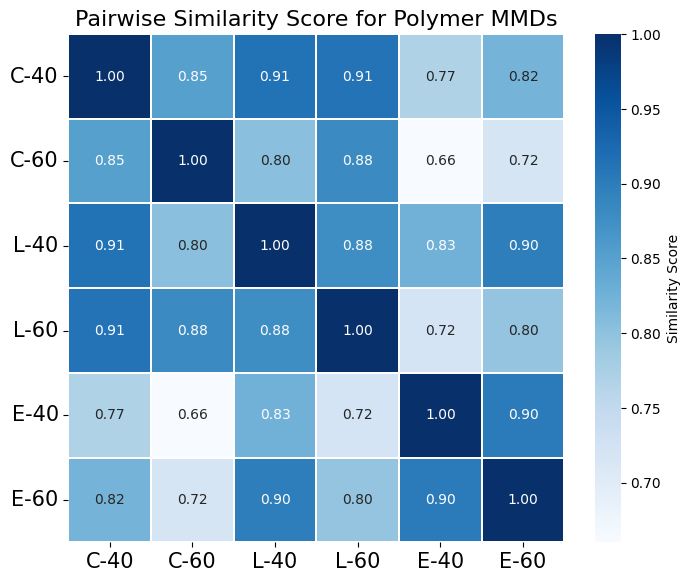

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6.6), sharey=True)

x_labels = ["C-40", "C-60", "L-40", "L-60", "E-40", "E-60"]
y_labels = ["C-40", "C-60", "L-40", "L-60", "E-40", "E-60"]

sns.heatmap(
    S_Matrix,
    linewidth=0.3,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Similarity Score"},
)
ax.set_title(r"Pairwise Similarity Score for Polymer MMDs", fontsize=16)
ax.set_xticklabels(x_labels, rotation=0, fontsize=15, horizontalalignment="center")
ax.set_yticklabels(y_labels, rotation=360, fontsize=15, horizontalalignment="right")

plt.show()